<a href="https://colab.research.google.com/github/essteer/data-science/blob/main/src/nlp/nlp_nltk_web_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP - Web Scrape to NLTK

This notebook explores basic applications of the NLTK (natural language toolkit) library to text scraped from a website.

In [ ]:
import requests, time
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from heapq import nlargest
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
nltk.download("stopwords")

In [ ]:
nltk.download("wordnet")

### Scrape article

In [ ]:
ENCODING = "utf-8"
# Response codes
GOOD_RESPONSES = [200]
RETRY_RESPONSES = [429]
BAD_RESPONSES = [400, 401, 403, 404, 500, 502, 504]

In [ ]:
header = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9;q=0.7,zh-CN;q=0.6,zh;q=0.5",
    "Referer": "https://www.google.com/",
    "Sec-Fetch-Dest": "document",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Site": "none",
    "Sec-Fetch-User": "?1",
    "Upgrade-Insecure-Requests": "1",
}

In [ ]:
def extractor(url: str, header: dict) -> str | bool:
    """
    Extracts HTML from a user-provided URL
    Args:
        - url, str, URL provided by user
    Returns:
        - html, str, HTML extracted from url, or
        - False, bool, if HTML extract fails
    """
    global GOOD_RESPONSES, RETRY_RESPONSES, BAD_RESPONSES
    # Assign weighted random referer and user-agent to header
    referer = "https://www.google.com/"
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"
    header["Referer"] = referer
    header["User-Agent"] = user_agent
    # Make request and catch response errors and retry
    for i in range(3):
        target_html = requests.get(url, headers=header)

        if isinstance(target_html, requests.models.Response):
            if target_html.status_code not in RETRY_RESPONSES:
                break
            else:  # Exponential delay before each retry
                time.sleep(2**(i+1))

    if isinstance(target_html, requests.models.Response):
        if target_html.status_code not in GOOD_RESPONSES:
            return False

    # Extract and parse html source code
    target_URL_source_code = target_html.text
    raw_html = BeautifulSoup(target_URL_source_code, "html.parser")

    return raw_html



In [ ]:
html = extractor("https://www.newyorker.com/magazine/2014/02/17/old-man-3", header)

In [ ]:
html == False

False

In [ ]:
# HTML element for this specific article
article = html.find("article", class_="article main-content")

In [ ]:
len(article.text)

28737

In [ ]:
text = article.text

In [ ]:
text = text.lower()

### Tokenise sentences and words

In [ ]:
sentences = sent_tokenize(text)

In [ ]:
sentences[:10]

['onward and outwardthis old manby roger angellfebruary 9, 2014roger angell and andy; central park, january, 2014.photograph by brigitte lacombesave this storysave this storysave this storysave this storycheck me out.',
 'the top two knuckles of my left hand look as if i’d been worked over by the k.g.b.',
 'no, it’s more as if i’d been a catcher for the hall of fame pitcher candy cummings, the inventor of the curveball, who retired from the game in 1877. to put this another way, if i pointed that hand at you like a pistol and fired at your nose, the bullet would nail you in the left knee.',
 'arthritis.now, still facing you, if i cover my left, or better, eye with one hand, what i see is a blurry encircling version of the ceiling and floor and walls or windows to our right and left but no sign of your face or head: nothing in the middle.',
 'but cheer up: if i reverse things and cover my right eye, there you are, back again.',
 'if i take my hand away and look at you with both eyes, th

In [ ]:
temp_text = text.split(".")

In [ ]:
text = " ".join(temp_text)

In [ ]:
words = word_tokenize(text)

In [ ]:
print(words[:100])

['onward', 'and', 'outwardthis', 'old', 'manby', 'roger', 'angellfebruary', '9', ',', '2014roger', 'angell', 'and', 'andy', ';', 'central', 'park', ',', 'january', ',', '2014', 'photograph', 'by', 'brigitte', 'lacombesave', 'this', 'storysave', 'this', 'storysave', 'this', 'storysave', 'this', 'storycheck', 'me', 'out', 'the', 'top', 'two', 'knuckles', 'of', 'my', 'left', 'hand', 'look', 'as', 'if', 'i', '’', 'd', 'been', 'worked', 'over', 'by', 'the', 'k', 'g', 'b', 'no', ',', 'it', '’', 's', 'more', 'as', 'if', 'i', '’', 'd', 'been', 'a', 'catcher', 'for', 'the', 'hall', 'of', 'fame', 'pitcher', 'candy', 'cummings', ',', 'the', 'inventor', 'of', 'the', 'curveball', ',', 'who', 'retired', 'from', 'the', 'game', 'in', '1877', 'to', 'put', 'this', 'another', 'way', ',', 'if', 'i']


### Remove stopwords and punctuation

In [ ]:
stop_words = set(stopwords.words("english") + list(punctuation))
# Add custom puncutation found within the text
stop_words.update("’", "“", "”", "—", ".")

In [ ]:
len(words)

5994

In [ ]:
stripped_text = [word for word in words if word not in stop_words]

In [ ]:
len(stripped_text)

2692

In [ ]:
text_sans_stopwords = " ".join(stripped_text)

In [ ]:
text_sans_stopwords[:1000]

'onward outwardthis old manby roger angellfebruary 9 2014roger angell andy central park january 2014 photograph brigitte lacombesave storysave storysave storysave storycheck top two knuckles left hand look worked k g b catcher hall fame pitcher candy cummings inventor curveball retired game 1877 put another way pointed hand like pistol fired nose bullet would nail left knee arthritis still facing cover left better eye one hand see blurry encircling version ceiling floor walls windows right left sign face head nothing middle cheer reverse things cover right eye back take hand away look eyes empty hole disappears 3-d actually looking pretty terrific today macular degeneration ninety-three feeling great well pretty great unless forgotten take couple tylenols past four five hours case begun feel jagged little pains shooting left forearm base thumb shingles 1996 resultant nerve damage like many men women age get around couple arterial stents keep heart chunking also sport minute plastic sea

### Lemmatise words (without stopwords)

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download("wordnet")

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
words_sans_stopwords = word_tokenize(text_sans_stopwords)

In [ ]:
lemmatized_words_sans_stopwords = [lemmatizer.lemmatize(word, pos="v") for word in words_sans_stopwords]

In [ ]:
text_lemmatized_sans_stopwords = " ".join(lemmatized_words_sans_stopwords)

In [ ]:
text_lemmatized_sans_stopwords[:1000]

'onward outwardthis old manby roger angellfebruary 9 2014roger angell andy central park january 2014 photograph brigitte lacombesave storysave storysave storysave storycheck top two knuckle leave hand look work k g b catcher hall fame pitcher candy cummings inventor curveball retire game 1877 put another way point hand like pistol fire nose bullet would nail leave knee arthritis still face cover leave better eye one hand see blurry encircle version ceiling floor wall windows right leave sign face head nothing middle cheer reverse things cover right eye back take hand away look eye empty hole disappear 3-d actually look pretty terrific today macular degeneration ninety-three feel great well pretty great unless forget take couple tylenols past four five hours case begin feel jag little pain shoot leave forearm base thumb shingle 1996 resultant nerve damage like many men women age get around couple arterial stents keep heart chunk also sport minute plastic seashell clamp shut congenital h

### Summarise

In [ ]:
from nltk.probability import FreqDist

In [ ]:
# Frequency distribution
frequencies = FreqDist(words_sans_stopwords)

In [ ]:
frequencies

FreqDist({'us': 23, 'said': 17, 'old': 15, 'still': 14, 'dead': 14, 'death': 14, 'one': 13, 'another': 12, 'like': 12, 'back': 12, ...})

In [ ]:
counter = 0
for k, v in frequencies.items():
    if counter == 10:
        break
    print(f"{v:>5} - {k}")
    counter += 1

    1 - onward
    1 - outwardthis
   15 - old
    1 - manby
    1 - roger
    1 - angellfebruary
    1 - 9
    1 - 2014roger
    1 - angell
    2 - andy


In [ ]:
from heapq import nlargest

In [ ]:
# Get n-largest words by frequency
nlargest(20, frequencies, key=frequencies.get)

['us',
 'said',
 'old',
 'still',
 'dead',
 'death',
 'one',
 'another',
 'like',
 'back',
 'left',
 'years',
 'two',
 'well',
 'little',
 'also',
 'know',
 'couple',
 'age',
 'around']

In [ ]:
from collections import defaultdict

In [ ]:
ranking = defaultdict(int)

# Rank sentences based on frequencies of words contained
for i, sent in enumerate(sentences):
    for w in word_tokenize(sent):
        if w in frequencies:
            ranking[i] += frequencies[w]

In [ ]:
print(ranking)

defaultdict(<class 'int'>, {0: 43, 1: 36, 2: 82, 3: 97, 4: 29, 5: 41, 6: 10, 7: 86, 8: 56, 9: 28, 10: 29, 11: 94, 12: 13, 13: 72, 14: 25, 15: 60, 16: 99, 17: 21, 18: 14, 19: 22, 20: 33, 21: 25, 22: 15, 23: 60, 24: 35, 25: 4, 26: 62, 27: 55, 28: 36, 29: 7, 30: 67, 31: 25, 32: 9, 33: 71, 34: 18, 35: 69, 36: 29, 38: 11, 39: 2, 40: 37, 41: 42, 42: 61, 43: 50, 44: 85, 45: 11, 46: 129, 47: 2, 48: 51, 49: 31, 50: 56, 51: 27, 52: 28, 53: 26, 54: 84, 55: 6, 56: 89, 57: 88, 58: 34, 59: 22, 60: 13, 61: 5, 62: 13, 63: 4, 64: 3, 65: 2, 66: 9, 67: 3, 68: 3, 69: 4, 70: 2, 71: 13, 72: 2, 73: 2, 74: 3, 75: 2, 76: 34, 77: 11, 78: 32, 79: 2, 80: 2, 81: 2, 82: 13, 83: 2, 84: 2, 85: 2, 86: 1, 87: 1, 88: 32, 89: 44, 90: 74, 91: 10, 92: 72, 93: 10, 94: 29, 95: 9, 96: 1, 97: 18, 98: 49, 99: 28, 100: 3, 101: 53, 102: 55, 103: 11, 104: 30, 105: 76, 107: 15, 108: 48, 109: 48, 110: 21, 111: 43, 112: 30, 113: 26, 114: 15, 115: 19, 116: 1, 117: 6, 118: 18, 119: 15, 120: 24, 121: 12, 122: 40, 123: 61, 124: 16, 125: 

In [ ]:
# Get the five highest-ranked sentences
sentences_index = nlargest(5, ranking, key=ranking.get)
sentences_index

[166, 250, 46, 233, 245]

In [ ]:
sentences[166]

'death will get it on with me eventually, and stay much too long, and though i’m in no hurry about the meeting, i feel i know him almost too well by now.a weariness about death exists in me and in us all in another way, as well, though we scarcely notice it.'

In [ ]:
sentences[250]

'for us and for anyone this unsettles, anyone who’s younger and still squirms at the vision of an old couple embracing, i’d offer john updike’s “sex or death: you take your pick”—a line that appears (in a slightly different form) in a late story of his, “playing with dynamite.”this is a great question, an excellent insurance-plan choice, i mean.'

In [ ]:
sentences[46]

'when harry died, carol and i couldn’t stop weeping; we sat in the bathroom with his retrieved body on a mat between us, the light-brown patches on his back and the near-black of his ears still darkened by the rain, and passed a kleenex box back and forth between us.'

In [ ]:
sentences[233]

'carol said this last: “if you haven’t found someone else by a year after i’m gone i’ll come back and haunt you.”getting old is the second-biggest surprise of my life, but the first, by a mile, is our unceasing need for deep attachment and intimate love.'

In [ ]:
sentences[245]

'he called her “kid.” an eighty-plus, twice-widowed lady i’d once known found still another love, a frail but vibrant midwest professor, now close to ninety, and the pair got in two or three happy years together before he died as well.'

#### Generate wordcloud based on the lemmatised text without stopwords

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

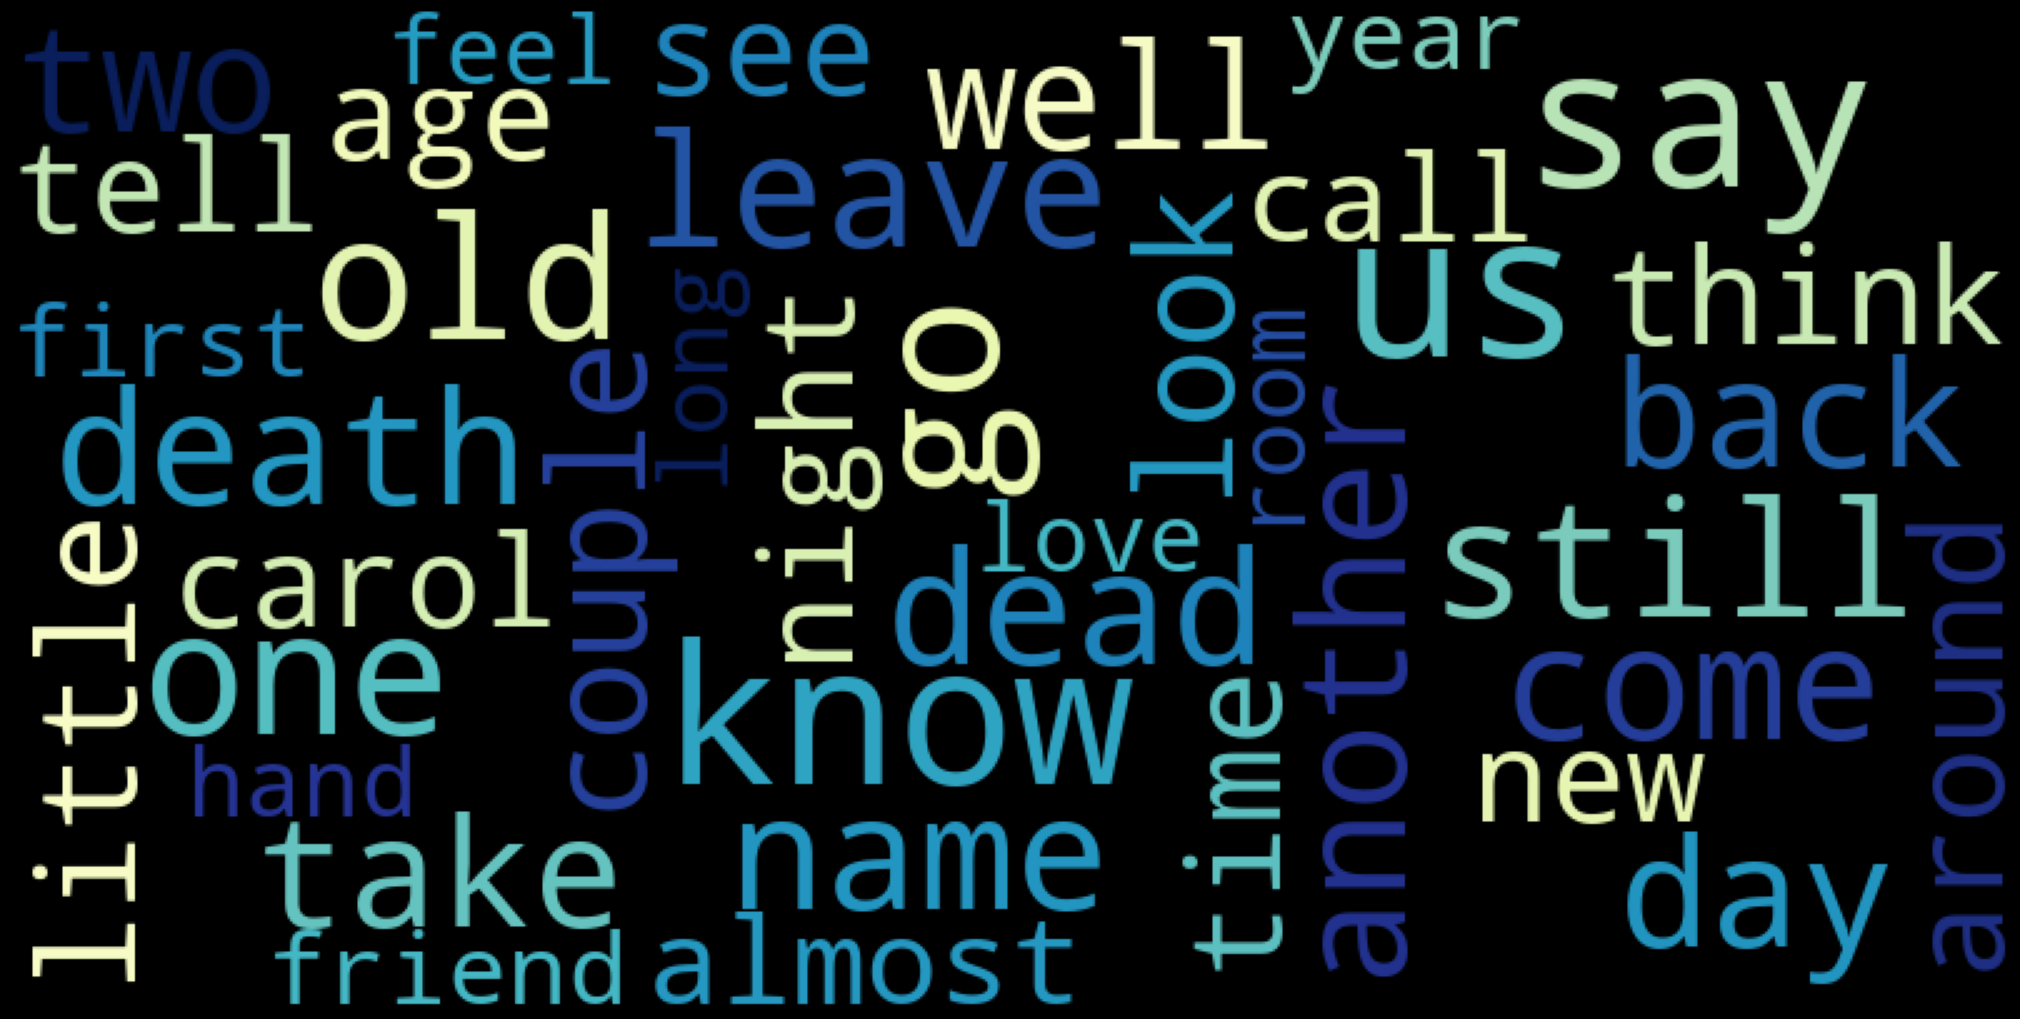

In [ ]:
wordcloud = WordCloud(
    # Set width and height to prevent image blurring
    width=800, height=400,
    max_font_size=80,
    max_words=40,
    colormap = "YlGnBu"
).generate(text_lemmatized_sans_stopwords)

# Create wordcloud
plt.figure(figsize=(20,10), facecolor="k")  # Set facecolor to make border colour same
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)  # Set pad=0 to remove border
plt.show()